<a href="https://colab.research.google.com/github/livjab/DS-Unit-1-Sprint-4-Statistical-Tests-and-Experiments/blob/master/DS_Unit_1_Sprint_Challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Unit 1 Sprint Challenge 4

## Exploring Data, Testing Hypotheses

In this sprint challenge you will look at a dataset of people being approved or rejected for credit.

https://archive.ics.uci.edu/ml/datasets/Credit+Approval

Data Set Information: This file concerns credit card applications. All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data. This dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values. There are also a few missing values.

Attribute Information:
- A1: b, a.
- A2: continuous.
- A3: continuous.
- A4: u, y, l, t.
- A5: g, p, gg.
- A6: c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.
- A7: v, h, bb, j, n, z, dd, ff, o.
- A8: continuous.
- A9: t, f.
- A10: t, f.
- A11: continuous.
- A12: t, f.
- A13: g, p, s.
- A14: continuous.
- A15: continuous.
- A16: +,- (class attribute)

Yes, most of that doesn't mean anything. A16 (the class attribute) is the most interesting, as it separates the 307 approved cases from the 383 rejected cases. The remaining variables have been obfuscated for privacy - a challenge you may have to deal with in your data science career.

Sprint challenges are evaluated based on satisfactory completion of each part. It is suggested you work through it in order, getting each aspect reasonably working, before trying to deeply explore, iterate, or refine any given step. Once you get to the end, if you want to go back and improve things, go for it!

## Part 1 - Load and validate the data

- Load the data as a `pandas` data frame.
- Validate that it has the appropriate number of observations (you can check the raw file, and also read the dataset description from UCI).
- UCI says there should be missing data - check, and if necessary change the data so pandas recognizes it as na
- Make sure that the loaded features are of the types described above (continuous values should be treated as float), and correct as necessary

This is review, but skills that you'll use at the start of any data exploration. Further, you may have to do some investigation to figure out which file to load from - that is part of the puzzle.

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data

--2019-04-12 16:00:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32218 (31K) [application/x-httpd-php]
Saving to: ‘crx.data.1’

crx.data.1          100%[===================>]  31.46K  --.-KB/s    in 0.03s   

2019-04-12 16:00:47 (1022 KB/s) - ‘crx.data.1’ saved [32218/32218]



In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
df = pd.read_csv("crx.data", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


### From UCI --

Number of Instances: 690

Number of Attributes: 15
( plus final column for approved/rejected
)

In [4]:
df.shape

(690, 16)

In [5]:
# check for types of missing values

df[0].value_counts()

b    468
a    210
?     12
Name: 0, dtype: int64

In [0]:
# replace all "?" with Nan

df = df.replace({"?":np.NaN})

In [7]:
# check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
0     678 non-null object
1     678 non-null object
2     690 non-null float64
3     684 non-null object
4     684 non-null object
5     681 non-null object
6     681 non-null object
7     690 non-null float64
8     690 non-null object
9     690 non-null object
10    690 non-null int64
11    690 non-null object
12    690 non-null object
13    677 non-null object
14    690 non-null int64
15    690 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 86.3+ KB


### Compare Types
A1: b, a.

A2: continuous.

A3: continuous.

A4: u, y, l, t.

A5: g, p, gg.

A6: c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.

A7: v, h, bb, j, n, z, dd, ff, o.

A8: continuous.

A9: t, f.

A10: t, f.

A11: continuous.

A12: t, f.

A13: g, p, s.

A14: continuous.

A15: continuous.

A16: +,- (class attribute)

In [0]:
# change continuous features to float

df[1] = df[1].astype('float64')
df[10] = df[10].astype('float64')


In [0]:
# had some trouble with these two columns, trying a new tactic

pd.to_numeric(df[13], errors='coerce')
pd.to_numeric(df[14], errors='coerce')

df[13] = df[13].astype('float64')
df[14] = df[14].astype('float64')

In [12]:
# check dtypes again

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
0     678 non-null object
1     678 non-null float64
2     690 non-null float64
3     684 non-null object
4     684 non-null object
5     681 non-null object
6     681 non-null object
7     690 non-null float64
8     690 non-null object
9     690 non-null object
10    690 non-null float64
11    690 non-null object
12    690 non-null object
13    677 non-null float64
14    690 non-null float64
15    690 non-null object
dtypes: float64(6), object(10)
memory usage: 86.3+ KB


## Part 2 - Exploring data, Testing hypotheses

The only thing we really know about this data is that A16 is the class label. Besides that, we have 6 continuous (float) features and 9 categorical features.

Explore the data: you can use whatever approach (tables, utility functions, visualizations) to get an impression of the distributions and relationships of the variables. In general, your goal is to understand how the features are different when grouped by the two class labels (`+` and `-`).

For the 6 continuous features, how are they different when split between the two class labels? Choose two features to run t-tests (again split by class label) - specifically, select one feature that is *extremely* different between the classes, and another feature that is notably less different (though perhaps still "statistically significantly" different). You may have to explore more than two features to do this.

For the categorical features, explore by creating "cross tabs" (aka [contingency tables](https://en.wikipedia.org/wiki/Contingency_table)) between them and the class label, and apply the Chi-squared test to them. [pandas.crosstab](http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html) can create contingency tables, and [scipy.stats.chi2_contingency](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html) can calculate the Chi-squared statistic for them.

There are 9 categorical features - as with the t-test, try to find one where the Chi-squared test returns an extreme result (rejecting the null that the data are independent), and one where it is less extreme.

**NOTE** - "less extreme" just means smaller test statistic/larger p-value. Even the least extreme differences may be strongly statistically significant.

Your *main* goal is the hypothesis tests, so don't spend too much time on the exploration/visualization piece. That is just a means to an end - use simple visualizations, such as boxplots or a scatter matrix (both built in to pandas), to get a feel for the overall distribution of the variables.

This is challenging, so manage your time and aim for a baseline of at least running two t-tests and two Chi-squared tests before polishing. And don't forget to answer the questions in part 3, even if your results in this part aren't what you want them to be.

In [21]:
df.describe(include="all")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,678,678.000000,690.000000,684,684,681,681,690.000000,690,690,690.00000,690,690,677.000000,690.000000,690
unique,2,NaN,NaN,3,3,14,9,NaN,2,2,NaN,2,3,NaN,NaN,2
top,b,NaN,NaN,u,g,c,v,NaN,t,f,NaN,f,g,NaN,NaN,-
freq,468,NaN,NaN,519,519,137,399,NaN,361,395,NaN,374,625,NaN,NaN,383
mean,NaN,31.568171,4.758725,NaN,NaN,NaN,NaN,2.223406,NaN,NaN,2.40000,NaN,NaN,184.014771,1017.385507,NaN
std,NaN,11.957862,4.978163,NaN,NaN,NaN,NaN,3.346513,NaN,NaN,4.86294,NaN,NaN,173.806768,5210.102598,NaN
min,NaN,13.750000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.00000,NaN,NaN,0.000000,0.000000,NaN
25%,NaN,22.602500,1.000000,NaN,NaN,NaN,NaN,0.165000,NaN,NaN,0.00000,NaN,NaN,75.000000,0.000000,NaN
50%,NaN,28.460000,2.750000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.00000,NaN,NaN,160.000000,5.000000,NaN
75%,NaN,38.230000,7.207500,NaN,NaN,NaN,NaN,2.625000,NaN,NaN,3.00000,NaN,NaN,276.000000,395.500000,NaN


In [0]:
# explore some differences between + and - in numeric columns

In [31]:
df[1].groupby(df[15]).mean()

15
+    33.720492
-    29.808231
Name: 1, dtype: float64

In [32]:
df[2].groupby(df[15]).mean()

15
+    5.904951
-    3.839948
Name: 2, dtype: float64

In [37]:
df[7].groupby(df[15]).mean()

15
+    3.427899
-    1.257924
Name: 7, dtype: float64

In [34]:
df[10].groupby(df[15]).mean()

15
+    4.605863
-    0.631854
Name: 10, dtype: float64

In [35]:
df[13].groupby(df[15]).mean()

15
+    164.421927
-    199.699468
Name: 13, dtype: float64

In [36]:
df[14].groupby(df[15]).mean()

15
+    2038.859935
-     198.605744
Name: 14, dtype: float64

In [14]:
# split into 2 datasets for + / -

df[15].value_counts() 

-    383
+    307
Name: 15, dtype: int64

In [16]:
accepted = df[df[15] == "+"]
accepted.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1.0,f,g,202.0,0.0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6.0,f,g,43.0,560.0,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0.0,f,g,280.0,824.0,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5.0,t,g,100.0,3.0,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0.0,f,s,120.0,0.0,+


In [18]:
rejected = df[df[15] == "-"]
rejected.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
70,b,32.33,7.5,u,g,e,bb,1.585,t,f,0.0,t,s,420.0,0.0,-
71,b,34.83,4.0,u,g,d,bb,12.500,t,f,0.0,t,g,NaN,0.0,-
72,a,38.58,5.0,u,g,cc,v,13.500,t,f,0.0,t,g,980.0,0.0,-
73,b,44.25,0.5,u,g,m,v,10.750,t,f,0.0,f,s,400.0,0.0,-
74,b,44.83,7.0,y,p,c,v,1.625,f,f,0.0,f,g,160.0,2.0,-


In [0]:
# changing column 15 to 0s and 1s might help for t test when comparing .5 liklihood of being accpeted

In [0]:
df = df.replace({"-":0, "+":1})

In [0]:
# pair plot to check outa few things

import seaborn as sns

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


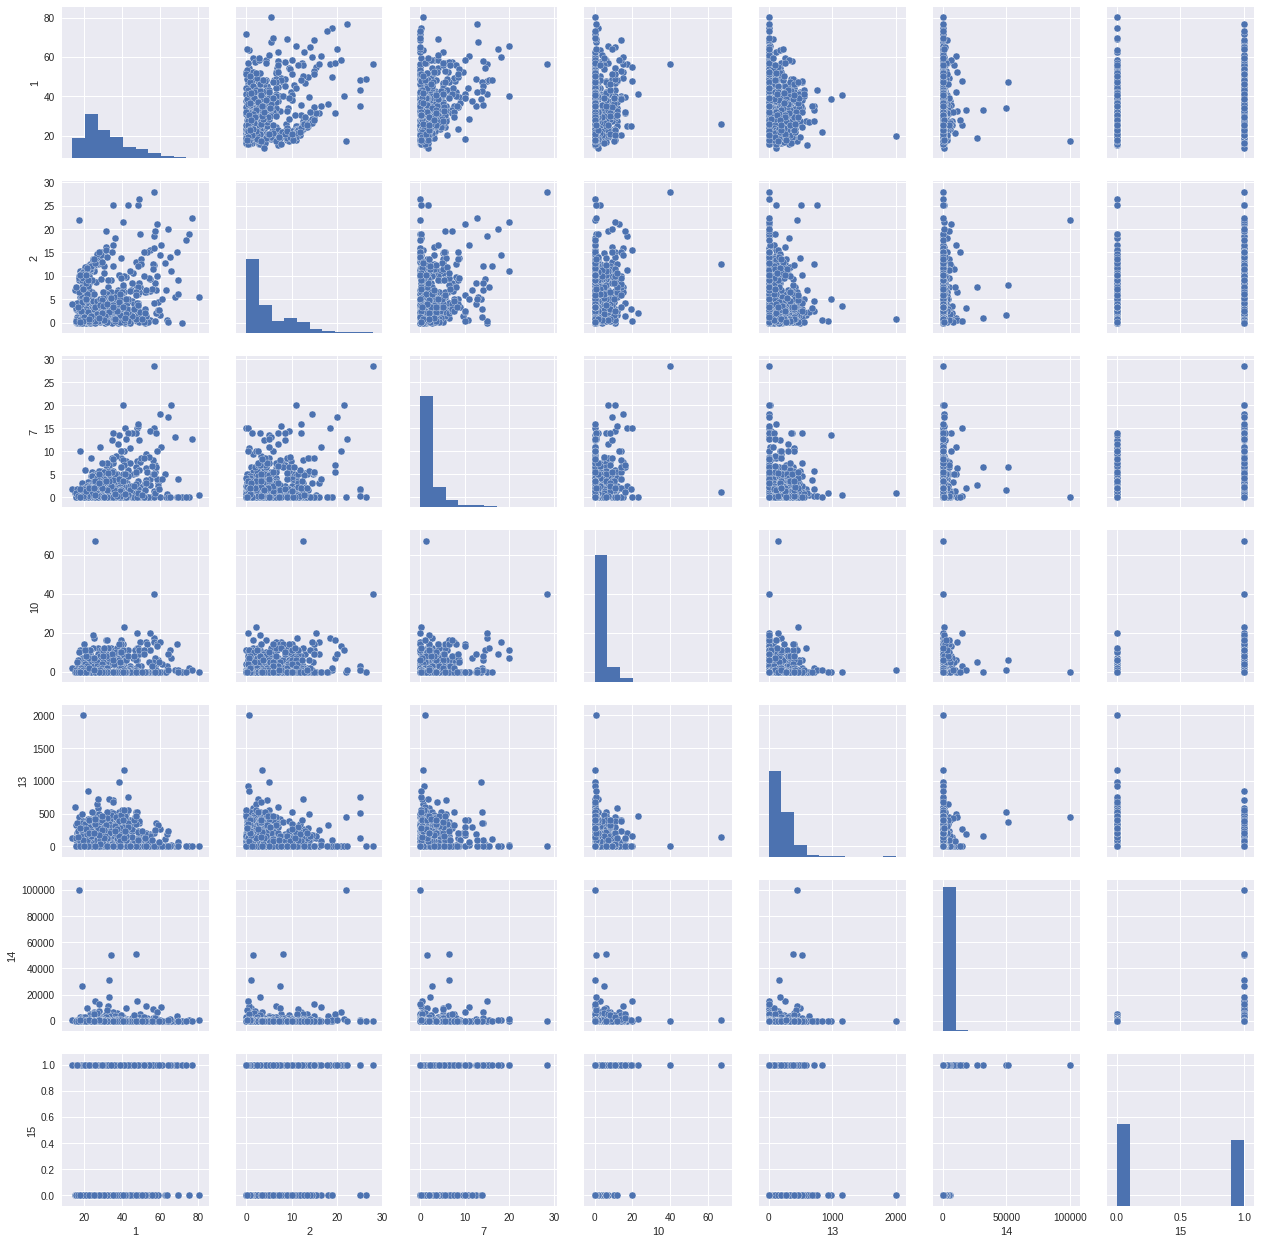

In [53]:
sns.pairplot(df);

### T test

In [38]:
# column 14 has the largest difference between means so I'll start there

# 2 sample t test between accepted and rejected
# null hypothesis is that accepted[14] and rejected[14] means are equal

stats.ttest_ind(accepted[14], rejected[14], nan_policy='omit')

Ttest_indResult(statistic=4.680216020964486, pvalue=3.4520256956287944e-06)

In [0]:
# positive t statistic means that the "accepted" mean is higher than the "rejected" mean
# p value < .05 means that we can reject null hypothesis 

In [39]:
# will try a column with closer means, and smaller standard deviation

# 2 sample t test between accepted and rejected
# null hypothesis is that accepted[7] and rejected[7] means are equal

stats.ttest_ind(accepted[7], rejected[7], nan_policy='omit')

Ttest_indResult(statistic=8.935819983773698, pvalue=3.6710537401601785e-18)

In [0]:
# similar results as above, although a higher statistical significance (smaller p value)

In [55]:
# lets try a one sample t test on column 2

# null hypothesis is that accepted[2] has a mean of .5

stats.ttest_1samp(accepted[2], .5, nan_policy='omit')

Ttest_1sampResult(statistic=17.30835312313626, pvalue=2.8402779104335877e-47)

In [0]:
# we can reject the null hypothesis

In [56]:
# null hypothesis is that rejected[2] has a mean of .5

stats.ttest_1samp(rejected[2], .5, nan_policy='omit')

Ttest_1sampResult(statistic=15.068962886128801, pvalue=1.3340212686882321e-40)

In [0]:
# reject null bypothesis

In [57]:
# compare against each other in a 2 sample
# null hypothesis that means are equal

stats.ttest_ind(accepted[2], rejected[2], nan_policy='omit')

Ttest_indResult(statistic=5.52998337614816, pvalue=4.551680702308068e-08)

In [0]:
# less statistically significant, but still reject null

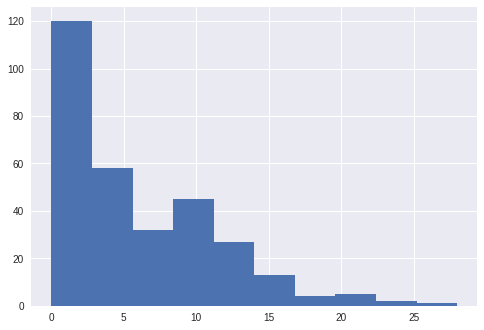

In [59]:
accepted[2].hist();

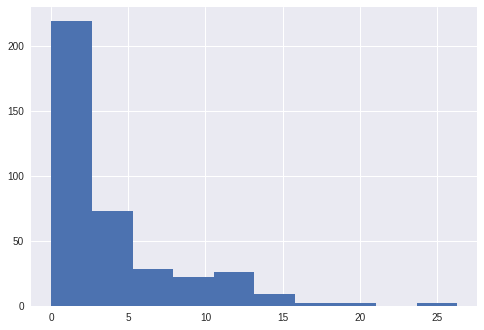

In [61]:
rejected[2].hist();

### Chi square test

In [42]:
# crosstab of column 8 with +/- column
# null hypothesis that these are independent

contingency_table = pd.crosstab(df[8], df[15])
contingency_table

15,+,-
8,,
f,23,306
t,284,77


In [44]:
chi_squared, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Squared: {chi_squared}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}") 
print("Expected: \n", np.array(expected))

Chi-Squared: 355.2038167412799
P-value: 3.1185900878457007e-79
Degrees of Freedom: 1
Expected: 
 [[146.38115942 182.61884058]
 [160.61884058 200.38115942]]


In [0]:
# reject null hypothesis
# whether or not someone is accepted seems very dependent on this feature
# could be something like "Does applicant have a job currently, T/F"

In [46]:
# let's try a column with more than 2 values
# crosstab of column 6 with +/- column
# null hypothesis that these are independent

contingency_table2 = pd.crosstab(df[6], df[15])
contingency_table2

15,+,-
6,,
bb,25,34
dd,2,4
ff,8,49
h,87,51
j,3,5
n,2,2
o,1,1
v,169,230
z,6,2


In [48]:
chi_squared, p_value, dof, expected = stats.chi2_contingency(contingency_table2)

print(f"Chi-Squared: {chi_squared}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}") 
print("Expected: \n", np.array(expected))

Chi-Squared: 45.03420714024056
P-value: 3.62545287237226e-07
Degrees of Freedom: 8
Expected: 
 [[ 26.25110132  32.74889868]
 [  2.66960352   3.33039648]
 [ 25.36123348  31.63876652]
 [ 61.40088106  76.59911894]
 [  3.55947137   4.44052863]
 [  1.77973568   2.22026432]
 [  0.88986784   1.11013216]
 [177.52863436 221.47136564]
 [  3.55947137   4.44052863]]


In [0]:
# smaller p value, but still statitically significant (reject null hypothesis)

## Part 3 - Analysis and Interpretation

Now that you've looked at the data, answer the following questions:

- Interpret and explain the two t-tests you ran - what do they tell you about the relationships between the continuous features you selected and the class labels?
- Interpret and explain the two Chi-squared tests you ran - what do they tell you about the relationships between the categorical features you selected and the class labels?
- What was the most challenging part of this sprint challenge?

Answer with text, but feel free to intersperse example code/results or refer to it from earlier.

*Your words here!*

## T-Test

The first t-test I ran was for column 14 because the means between accepted and rejected were very different, which I thought might be an important indication.

- t statstic = 4.680216020964486
- p value = 3.4520256956287944e-06

- I ran a 2 sample t test with the null hypothesis that the means between "accepted" and "rejected" were equal.

- The positive t statistic means that the "accepted" mean is higher than the "rejected" mean

- The p value < .05 means that we can reject null hypothesis


The second t-test I chose to run had closer means, and a smaller standard deviation

- t statistic = 8.935819983773698
- p value = 3.6710537401601785e-18

- I ran a 2 sample test with the null hypothesis that the means between "accepted"  and "rejected" were equal.

- The positive t statistic means that the "accpeted" mean is higher than the "rejected" mean.

- The p value of this test was  less that 0.5, and much smaller than the previous test, meaning that we can reject the null hypothesis.




I ran a couple more tests just to explore the data. I tried some 1 sample tests to compare against the idea that accepted and rejected were equal (0.5).

I concluded that whatever human or algorithm is determining  whether to accept/reject for a loan likely takes into account all of these columns, as all of the tests I did were statistically significant to reject the null.

## Chi Square

The first test that I ran used column 8, which only had 2 values (t/f)

- Chi-Squared: 355.2038167412799
- P-value: 3.1185900878457007e-79

- The null hypothesis is that these 2 columns are independent.

- The high chi-square value and low p value tell us to reject this hypothesis

- This indicates that column 8 is an important indication of whether someone is accepted for a loan or not. My theory is that this column asks the question "Does applicant have a job/income"

The second test I choose to run with column 6, which had a higher number of values , and therefore, higher degree of freedom.

- Chi-Squared: 45.03420714024056
- P-value: 3.62545287237226e-07

- The null hypothesis is that these 2 columns are independent.

- This test has a lower chi square value and a higher p value than the previous test, telling us that it is less statistically significant, but we should stil reject the null hypothesis.

## Sprint Challenge

The most difficult part for me was trying to make connections between the data without knowing what any of it meant. I realized today that a lot of my decision making about which columns to compare comes from prior knowledge or intuition about the information in the columns. 

